In [1]:
%matplotlib notebook

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [2]:
from tracker3d import utils
from tracker3d import metrics
from tracker3d import loader

import numpy as np
import pandas as pd

import keras

Using Theano backend.
Using cuDNN version 5110 on context None
Mapped name None to device cuda: GeForce GTX 1080 (0000:06:00.0)


In [5]:
order = ("phi", "r", "z")

In [6]:
train, target = loader.from_file("datasets/npz/unif25_prz_n10.npz")

In [7]:
#test = train[int(0.2 * len(train)):]
#train = train[:int(0.2 * len(train))]
#print(test.shape)
#print(train.shape)

In [8]:
#testTarget = target[int(0.2 * len(target)):]
#target = target[:int(0.2 * len(target))]
#print(testTarget.shape)
#print(target.shape)

In [9]:
test, testTarget = loader.from_file("datasets/npz/ramp_prz_n10.npz")

In [10]:
event = 1025
utils.display_side_by_side(train[event], target[event], order=order)

,phi,r,z
0,-2.983331,1000.0,-165.984650
1,-2.795776,762.0,-126.480309
2,-2.650811,562.0,-93.283379
3,-2.578860,39.0,7.786216
4,-2.561497,85.0,16.969959
5,-2.545817,405.0,-67.223785
6,-2.541046,155.0,30.945219
7,-2.523793,213.0,42.524719
8,-2.506083,271.0,54.104221
9,-2.466398,405.0,80.856857


In [11]:
from keras.layers import Dense, LSTM, Dropout, GRU, TimeDistributed, Bidirectional
from keras.models import Sequential
from keras.regularizers import l1, l2, l1_l2

In [12]:
input_shape = train[0].shape # Shape of an event.
output_shape = len(target[0][0]) # Number of tracks per event

batch_size = 32
epochs     = 32
valsplit   = .1
opt        = 'rmsprop' # optimizer
model = Sequential()
model.add(Bidirectional(GRU(256, return_sequences=True, recurrent_dropout=0.4, implementation=2, bias_regularizer=l2(0.02)), input_shape=input_shape, merge_mode="mul"))
model.add(Dropout(0.4))
model.add(Bidirectional(GRU(256, return_sequences=True, recurrent_dropout=0.4, implementation=2, bias_regularizer=l2(0.02)), merge_mode="mul"))
model.add(Dropout(0.4))
model.add(Bidirectional(GRU(256, return_sequences=True, recurrent_dropout=0.4, implementation=2, bias_regularizer=l2(0.02)), merge_mode="mul"))
model.add(Dropout(0.4))
model.add(TimeDistributed(Dense(output_shape, activation='softmax')))

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 233, 256)          399360    
_________________________________________________________________
dropout_1 (Dropout)          (None, 233, 256)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 233, 256)          787968    
_________________________________________________________________
dropout_2 (Dropout)          (None, 233, 256)          0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 233, 256)          787968    
_________________________________________________________________
dropout_3 (Dropout)          (None, 233, 256)          0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 233, 27)           6939      
Total para

In [13]:
%%time
modelpath = 'simple.h5'
hist = model.fit(train, target, epochs=epochs, batch_size=batch_size,
                         verbose=1, validation_split=valsplit,
                         #callbacks=[keras.callbacks.ModelCheckpoint(filepath=modelpath, verbose=0)]
                )

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


Train on 3593 samples, validate on 400 samples
Epoch 1/32
3593/3593 [==============================] - 96s - loss: 1.8215 - acc: 0.5886 - val_loss: 0.9353 - val_acc: 0.6626
Epoch 2/32
3593/3593 [==============================] - 95s - loss: 1.0117 - acc: 0.6473 - val_loss: 0.9653 - val_acc: 0.6397
Epoch 3/32
3593/3593 [==============================] - 96s - loss: 0.9274 - acc: 0.6652 - val_loss: 0.7432 - val_acc: 0.7255
Epoch 4/32
3593/3593 [==============================] - 97s - loss: 0.8565 - acc: 0.6836 - val_loss: 0.7838 - val_acc: 0.6915
Epoch 5/32
3593/3593 [==============================] - 96s - loss: 0.8167 - acc: 0.6937 - val_loss: 0.6669 - val_acc: 0.7403
Epoch 6/32
3593/3593 [==============================] - 95s - loss: 0.7765 - acc: 0.7080 - val_loss: 0.6568 - val_acc: 0.7593
Epoch 7/32
3593/3593 [==============================] - 96s - loss: 0.7378 - acc: 0.7206 - val_loss: 0.7282 - val_acc: 0.7021
Epoch 8/32
3593/3593 [==============================] - 97s - loss: 0.7

In [14]:
predictions = model.predict(test, batch_size=batch_size)

3993/3993 [==============================] - 25s    

Test Score:    0.30660705952425815
Test Accuracy: 0.8990583316950819


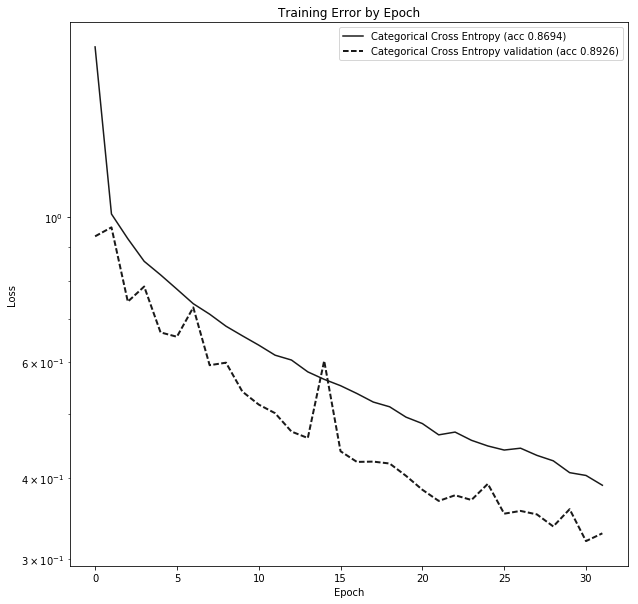

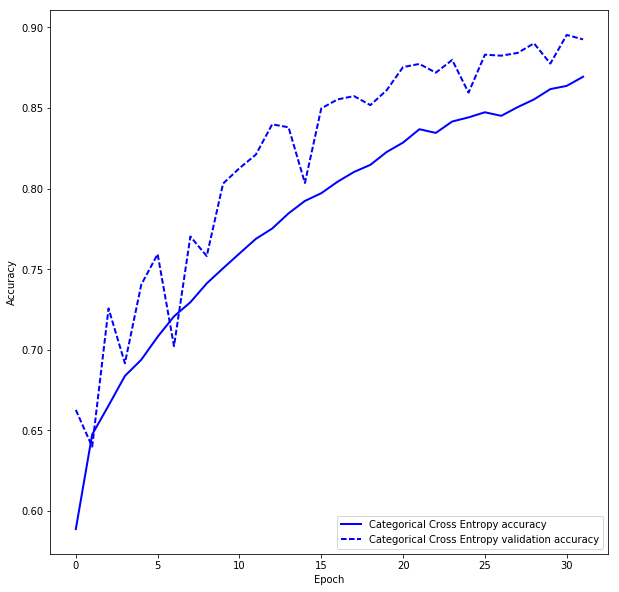

In [23]:
utils.print_scores(model, train, target, batch_size)
utils.graph_losses([("Categorical Cross Entropy", hist)])

In [16]:
tracks, acc = metrics.accuracy_vs_tracks(predictions, testTarget, has_noise=True, has_padding=True)

In [17]:
np.save("testTarget.npy", testTarget)
np.save("predictions.npy", predictions)

In [18]:
print(metrics.discrete_accuracy_all(test, testTarget, predictions))

0.0


In [19]:
print(acc)

[ 0.91954023  0.95918367  0.72262774 ...,  0.87719298  0.80571429
  0.78911565]


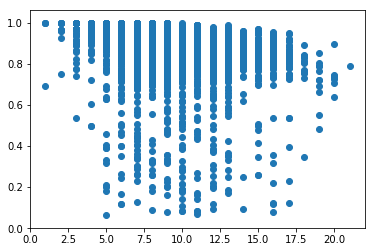

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(2)
fig = plt.scatter(tracks, acc)
plt.show(fig)

In [21]:
numTracks = int(np.amax(tracks))
accuracy = np.zeros(numTracks)
for i in range(numTracks):
    tot_acc = 0
    count = 0
    for j, track in enumerate(tracks):
        print(acc[j])
        if track == i + 1:
            tot_acc = tot_acc + acc[j]
            count += 1
    if count > 0:
        accuracy[i] = tot_acc/count

track = np.zeros(numTracks)

for i in range(numTracks):
    track[i] = i + 1
        
print(accuracy)
print(track)

0.919540229885
0.959183673469
0.722627737226
0.986666666667
0.887640449438
0.910447761194
0.971830985915
0.913043478261
0.952380952381
0.672268907563
0.896103896104
0.961538461538
0.869565217391
0.958333333333
0.888157894737
0.963414634146
0.910891089109
0.95
0.927083333333
1.0
0.909090909091
0.952380952381
0.903225806452
0.4140625
0.84
0.88785046729
0.867346938776
0.911392405063
0.909090909091
1.0
0.737704918033
0.916666666667
0.857142857143
0.988888888889
0.790322580645
0.845360824742
0.837398373984
0.876404494382
0.892857142857
0.904761904762
0.873417721519
0.766666666667
0.891891891892
0.977272727273
0.824074074074
0.910569105691
0.931623931624
0.962962962963
0.888888888889
0.71875
0.944444444444
0.646017699115
0.953703703704
0.941176470588
0.859813084112
0.794520547945
0.853846153846
0.917525773196
0.914285714286
0.954545454545
0.9375
0.878504672897
0.980769230769
0.759493670886
0.931034482759
0.932038834951
0.943181818182
0.78021978022
0.927536231884
0.892617449664
0.485294117647

0.964601769912
0.95652173913
0.96875
0.90990990991
0.84126984127
0.962264150943
0.915492957746
0.891891891892
0.931034482759
0.822429906542
0.918918918919
0.961538461538
0.952380952381
0.8375
0.87037037037
0.973684210526
0.771428571429
0.865546218487
0.785234899329
0.827272727273
1.0
0.933333333333
0.972972972973
1.0
0.453125
0.847457627119
0.906542056075
0.963855421687
0.481012658228
0.931506849315
0.84693877551
0.969696969697
0.924528301887
0.823529411765
1.0
0.8
0.974137931034
0.986301369863
0.894736842105
0.958904109589
0.842105263158
0.798245614035
0.907692307692
0.841584158416
0.901785714286
0.892857142857
0.74358974359
0.75
0.965517241379
0.864583333333
0.942028985507
0.965909090909
0.812030075188
0.853333333333
0.945454545455
0.974137931034
0.831168831169
0.931297709924
0.972972972973
0.905172413793
0.91
0.865979381443
0.685714285714
0.742857142857
0.821428571429
0.915094339623
0.821428571429
0.822784810127
0.981481481481
0.901234567901
0.894736842105
0.22619047619
0.8712121212

1.0
0.830508474576
0.805555555556
0.808823529412
0.916666666667
0.903846153846
0.766990291262
0.886363636364
0.888
0.930434782609
0.878260869565
0.722222222222
0.794871794872
0.966292134831
0.87012987013
0.125
0.95
0.879120879121
1.0
0.767441860465
0.905660377358
0.917808219178
0.754098360656
0.824561403509
0.901408450704
0.917808219178
1.0
0.927083333333
0.900900900901
0.931818181818
0.974683544304
0.948979591837
0.909090909091
0.862068965517
0.923728813559
0.821917808219
0.948979591837
0.986301369863
0.819444444444
0.921568627451
0.838983050847
0.920634920635
0.953703703704
0.849056603774
0.88679245283
0.87
0.886597938144
0.932584269663
0.886363636364
0.977272727273
0.952380952381
0.877192982456
0.805714285714
0.789115646259
0.919540229885
0.959183673469
0.722627737226
0.986666666667
0.887640449438
0.910447761194
0.971830985915
0.913043478261
0.952380952381
0.672268907563
0.896103896104
0.961538461538
0.869565217391
0.958333333333
0.888157894737
0.963414634146
0.910891089109
0.95
0.9

0.890410958904
0.818181818182
0.914634146341
0.983870967742
0.92
0.88
0.88
0.887323943662
0.80412371134
0.794326241135
0.861111111111
0.950495049505
0.927536231884
0.806451612903
0.742857142857
0.914634146341
0.911111111111
0.975308641975
0.966101694915
0.944444444444
0.78125
0.923076923077
0.928571428571
0.979591836735
0.821917808219
0.834951456311
0.971830985915
0.901960784314
0.850746268657
0.905263157895
0.9
0.879032258065
0.696202531646
0.838983050847
0.930434782609
0.851851851852
0.954545454545
0.802197802198
0.975609756098
0.782608695652
0.971014492754
0.975903614458
0.978723404255
0.791666666667
0.945205479452
0.878787878788
0.852272727273
0.929411764706
0.934426229508
0.947916666667
0.85
0.8
0.961538461538
0.891891891892
0.883561643836
0.88
0.887323943662
0.913978494624
0.932584269663
0.359375
0.842857142857
0.822222222222
0.90625
0.943396226415
0.803571428571
0.974683544304
0.87012987013
0.876033057851
0.95
0.927272727273
0.81308411215
0.990654205607
0.814814814815
0.81818181

0.839416058394
0.910714285714
0.895238095238
0.939393939394
0.880952380952
0.819047619048
0.738888888889
0.886363636364
0.87323943662
0.5
0.853146853147
0.814432989691
0.894230769231
0.973333333333
0.745614035088
0.908163265306
0.915789473684
0.798319327731
0.928571428571
0.573170731707
0.944444444444
0.947368421053
0.914893617021
0.838095238095
0.848
0.980392156863
0.941176470588
0.912621359223
0.957746478873
0.925925925926
0.963636363636
0.957746478873
0.245283018868
0.899159663866
0.942528735632
0.144230769231
0.897959183673
0.9375
0.888888888889
0.79797979798
0.944444444444
0.915094339623
0.795918367347
0.935483870968
0.985507246377
0.877551020408
0.950980392157
0.945054945055
0.215053763441
0.873417721519
0.935064935065
0.927272727273
0.868421052632
0.902912621359
0.951807228916
0.96875
0.987654320988
0.965909090909
0.947368421053
0.908045977011
0.933333333333
0.776699029126
0.909090909091
0.836956521739
0.847457627119
0.983870967742
0.881188118812
0.957142857143
0.927272727273
0.

0.724770642202
0.962264150943
0.869565217391
0.935185185185
0.888
0.901960784314
0.87610619469
0.923076923077
0.755319148936
0.963855421687
0.963855421687
0.648148148148
0.823008849558
0.825
0.939024390244
0.191919191919
0.950495049505
0.920454545455
0.972222222222
0.903225806452
0.845528455285
0.789473684211
0.839694656489
0.942857142857
0.888888888889
0.848684210526
0.942857142857
0.978723404255
0.893203883495
0.901639344262
0.821138211382
0.96875
0.764227642276
0.79746835443
0.948453608247
0.955555555556
0.64367816092
0.910447761194
0.847058823529
0.91935483871
0.75
0.857142857143
0.909090909091
0.923076923077
0.892156862745
0.809160305344
0.943181818182
0.338028169014
0.846153846154
1.0
0.956043956044
1.0
0.92380952381
0.860294117647
0.881944444444
0.934065934066
0.864864864865
0.958904109589
0.864583333333
0.870588235294
0.142857142857
0.928571428571
0.926315789474
0.978260869565
0.978723404255
0.915254237288
0.911504424779
0.978021978022
0.977777777778
0.864864864865
0.9259259259

0.496296296296
0.657142857143
0.930434782609
0.888888888889
0.96
0.892857142857
1.0
0.972972972973
0.972222222222
0.407407407407
0.861111111111
0.828947368421
0.958333333333
0.84126984127
0.981818181818
0.934959349593
0.907407407407
0.934959349593
0.598039215686
0.229299363057
0.919191919192
0.989583333333
0.387931034483
0.904761904762
1.0
1.0
0.968085106383
0.933333333333
0.885714285714
0.91
0.910714285714
0.960526315789
0.900900900901
0.923076923077
0.896907216495
0.857142857143
0.948717948718
0.906542056075
0.798076923077
0.974025974026
0.819047619048
0.936170212766
0.948979591837
0.792792792793
0.698630136986
0.841121495327
0.855670103093
0.504424778761
0.827956989247
0.920634920635
0.285714285714
0.839416058394
0.910714285714
0.895238095238
0.939393939394
0.880952380952
0.819047619048
0.738888888889
0.886363636364
0.87323943662
0.5
0.853146853147
0.814432989691
0.894230769231
0.973333333333
0.745614035088
0.908163265306
0.915789473684
0.798319327731
0.928571428571
0.573170731707
0

1.0
0.943661971831
0.957264957265
0.908045977011
0.953488372093
0.898305084746
0.953488372093
0.83908045977
0.933884297521
0.97619047619
0.928571428571
0.79797979798
0.976744186047
0.592
0.878787878788
0.924731182796
0.959459459459
0.921052631579
0.97037037037
0.90243902439
0.776119402985
0.791044776119
0.877551020408
0.875
0.888888888889
0.902654867257
0.916666666667
0.957746478873
1.0
0.701149425287
0.716814159292
0.866666666667
0.86231884058
0.87012987013
0.844155844156
0.882352941176
0.948979591837
0.904255319149
0.869158878505
0.981132075472
0.814432989691
0.482352941176
0.923076923077
0.822033898305
0.882352941176
0.820895522388
0.685185185185
0.724770642202
0.962264150943
0.869565217391
0.935185185185
0.888
0.901960784314
0.87610619469
0.923076923077
0.755319148936
0.963855421687
0.963855421687
0.648148148148
0.823008849558
0.825
0.939024390244
0.191919191919
0.950495049505
0.920454545455
0.972222222222
0.903225806452
0.845528455285
0.789473684211
0.839694656489
0.942857142857
0

0.975609756098
0.842105263158
0.95652173913
0.951612903226
0.739726027397
0.848484848485
0.794871794872
0.94495412844
0.942307692308
0.818181818182
0.833333333333
0.886075949367
0.929577464789
0.888888888889
0.873684210526
0.898734177215
0.884057971014
0.392156862745
0.966292134831
0.954022988506
0.820512820513
0.1875
0.864583333333
0.87619047619
0.847682119205
0.507936507937
0.967391304348
0.915887850467
0.957746478873
0.81746031746
0.987654320988
0.972222222222
0.921985815603
0.989361702128
0.909090909091
0.916030534351
0.95
0.728813559322
0.802469135802
0.93137254902
0.883720930233
0.970149253731
0.863309352518
0.910112359551
0.931506849315
0.861111111111
0.961538461538
0.861111111111
0.752941176471
0.913793103448
0.981818181818
0.802197802198
0.839622641509
0.941747572816
0.956989247312
0.784615384615
0.496296296296
0.657142857143
0.930434782609
0.888888888889
0.96
0.892857142857
1.0
0.972972972973
0.972222222222
0.407407407407
0.861111111111
0.828947368421
0.958333333333
0.8412698

0.92523364486
0.637931034483
0.84347826087
0.407407407407
0.929577464789
0.787234042553
0.986486486486
0.985915492958
0.875
0.116666666667
0.894308943089
0.737588652482
0.872549019608
0.939024390244
0.882882882883
1.0
0.943661971831
0.957264957265
0.908045977011
0.953488372093
0.898305084746
0.953488372093
0.83908045977
0.933884297521
0.97619047619
0.928571428571
0.79797979798
0.976744186047
0.592
0.878787878788
0.924731182796
0.959459459459
0.921052631579
0.97037037037
0.90243902439
0.776119402985
0.791044776119
0.877551020408
0.875
0.888888888889
0.902654867257
0.916666666667
0.957746478873
1.0
0.701149425287
0.716814159292
0.866666666667
0.86231884058
0.87012987013
0.844155844156
0.882352941176
0.948979591837
0.904255319149
0.869158878505
0.981132075472
0.814432989691
0.482352941176
0.923076923077
0.822033898305
0.882352941176
0.820895522388
0.685185185185
0.724770642202
0.962264150943
0.869565217391
0.935185185185
0.888
0.901960784314
0.87610619469
0.923076923077
0.755319148936
0.9

0.914893617021
0.947826086957
0.95
0.805555555556
0.819672131148
0.941176470588
0.876033057851
0.969072164948
0.898305084746
0.956043956044
0.856060606061
0.907894736842
1.0
0.964705882353
0.75
0.88679245283
0.975609756098
0.842105263158
0.95652173913
0.951612903226
0.739726027397
0.848484848485
0.794871794872
0.94495412844
0.942307692308
0.818181818182
0.833333333333
0.886075949367
0.929577464789
0.888888888889
0.873684210526
0.898734177215
0.884057971014
0.392156862745
0.966292134831
0.954022988506
0.820512820513
0.1875
0.864583333333
0.87619047619
0.847682119205
0.507936507937
0.967391304348
0.915887850467
0.957746478873
0.81746031746
0.987654320988
0.972222222222
0.921985815603
0.989361702128
0.909090909091
0.916030534351
0.95
0.728813559322
0.802469135802
0.93137254902
0.883720930233
0.970149253731
0.863309352518
0.910112359551
0.931506849315
0.861111111111
0.961538461538
0.861111111111
0.752941176471
0.913793103448
0.981818181818
0.802197802198
0.839622641509
0.941747572816
0.956

0.931034482759
0.858407079646
0.904255319149
0.816326530612
0.979166666667
0.910112359551
0.929824561404
0.971428571429
0.677966101695
0.913043478261
0.528846153846
0.954545454545
0.784
1.0
0.978021978022
0.964285714286
0.712765957447
0.986666666667
0.887323943662
1.0
0.867768595041
0.917910447761
0.941176470588
0.662337662338
0.971428571429
0.861788617886
0.855670103093
0.986842105263
0.945945945946
0.865168539326
0.807692307692
0.778947368421
0.903225806452
0.758823529412
0.959595959596
0.873015873016
0.916666666667
0.922330097087
0.92523364486
0.637931034483
0.84347826087
0.407407407407
0.929577464789
0.787234042553
0.986486486486
0.985915492958
0.875
0.116666666667
0.894308943089
0.737588652482
0.872549019608
0.939024390244
0.882882882883
1.0
0.943661971831
0.957264957265
0.908045977011
0.953488372093
0.898305084746
0.953488372093
0.83908045977
0.933884297521
0.97619047619
0.928571428571
0.79797979798
0.976744186047
0.592
0.878787878788
0.924731182796
0.959459459459
0.921052631579


0.863309352518
0.910112359551
0.931506849315
0.861111111111
0.961538461538
0.861111111111
0.752941176471
0.913793103448
0.981818181818
0.802197802198
0.839622641509
0.941747572816
0.956989247312
0.784615384615
0.496296296296
0.657142857143
0.930434782609
0.888888888889
0.96
0.892857142857
1.0
0.972972972973
0.972222222222
0.407407407407
0.861111111111
0.828947368421
0.958333333333
0.84126984127
0.981818181818
0.934959349593
0.907407407407
0.934959349593
0.598039215686
0.229299363057
0.919191919192
0.989583333333
0.387931034483
0.904761904762
1.0
1.0
0.968085106383
0.933333333333
0.885714285714
0.91
0.910714285714
0.960526315789
0.900900900901
0.923076923077
0.896907216495
0.857142857143
0.948717948718
0.906542056075
0.798076923077
0.974025974026
0.819047619048
0.936170212766
0.948979591837
0.792792792793
0.698630136986
0.841121495327
0.855670103093
0.504424778761
0.827956989247
0.920634920635
0.285714285714
0.839416058394
0.910714285714
0.895238095238
0.939393939394
0.880952380952
0.81

0.916666666667
0.922330097087
0.92523364486
0.637931034483
0.84347826087
0.407407407407
0.929577464789
0.787234042553
0.986486486486
0.985915492958
0.875
0.116666666667
0.894308943089
0.737588652482
0.872549019608
0.939024390244
0.882882882883
1.0
0.943661971831
0.957264957265
0.908045977011
0.953488372093
0.898305084746
0.953488372093
0.83908045977
0.933884297521
0.97619047619
0.928571428571
0.79797979798
0.976744186047
0.592
0.878787878788
0.924731182796
0.959459459459
0.921052631579
0.97037037037
0.90243902439
0.776119402985
0.791044776119
0.877551020408
0.875
0.888888888889
0.902654867257
0.916666666667
0.957746478873
1.0
0.701149425287
0.716814159292
0.866666666667
0.86231884058
0.87012987013
0.844155844156
0.882352941176
0.948979591837
0.904255319149
0.869158878505
0.981132075472
0.814432989691
0.482352941176
0.923076923077
0.822033898305
0.882352941176
0.820895522388
0.685185185185
0.724770642202
0.962264150943
0.869565217391
0.935185185185
0.888
0.901960784314
0.87610619469
0.9

0.933962264151
0.771428571429
0.916666666667
0.943925233645
0.864406779661
0.89
0.884615384615
0.965217391304
0.892561983471
0.85393258427
0.868686868687
0.978723404255
0.788617886179
0.964705882353
0.979591836735
0.835443037975
0.33064516129
0.938461538462
0.959183673469
0.94623655914
0.880341880342
0.942857142857
1.0
0.946808510638
0.944444444444
0.9
0.774509803922
0.907692307692
0.87012987013
0.983333333333
0.986111111111
0.375
0.82905982906
0.699300699301
0.946666666667
0.884615384615
0.922330097087
0.943820224719
0.927419354839
0.935483870968
0.967032967033
0.984848484848
0.848101265823
1.0
0.932203389831
0.972222222222
0.697183098592
0.441176470588
0.850746268657
0.919540229885
0.771653543307
0.935483870968
0.859375
0.942857142857
0.985915492958
1.0
0.947368421053
0.927835051546
0.946902654867
0.989010989011
0.980952380952
0.8
0.885416666667
0.949494949495
0.798387096774
0.763636363636
0.867346938776
0.897435897436
0.840277777778
0.932203389831
0.836734693878
0.967741935484
0.934

0.916666666667
0.922330097087
0.92523364486
0.637931034483
0.84347826087
0.407407407407
0.929577464789
0.787234042553
0.986486486486
0.985915492958
0.875
0.116666666667
0.894308943089
0.737588652482
0.872549019608
0.939024390244
0.882882882883
1.0
0.943661971831
0.957264957265
0.908045977011
0.953488372093
0.898305084746
0.953488372093
0.83908045977
0.933884297521
0.97619047619
0.928571428571
0.79797979798
0.976744186047
0.592
0.878787878788
0.924731182796
0.959459459459
0.921052631579
0.97037037037
0.90243902439
0.776119402985
0.791044776119
0.877551020408
0.875
0.888888888889
0.902654867257
0.916666666667
0.957746478873
1.0
0.701149425287
0.716814159292
0.866666666667
0.86231884058
0.87012987013
0.844155844156
0.882352941176
0.948979591837
0.904255319149
0.869158878505
0.981132075472
0.814432989691
0.482352941176
0.923076923077
0.822033898305
0.882352941176
0.820895522388
0.685185185185
0.724770642202
0.962264150943
0.869565217391
0.935185185185
0.888
0.901960784314
0.87610619469
0.9

0.627450980392
0.707865168539
0.741935483871
0.827272727273
0.814159292035
0.259259259259
0.847826086957
0.720930232558
1.0
0.948717948718
0.833333333333
0.927083333333
0.949579831933
0.679012345679
0.933333333333
0.879310344828
0.949152542373
0.969072164948
0.945205479452
0.806818181818
0.971428571429
0.747191011236
0.904
0.895238095238
0.241758241758
1.0
0.904109589041
0.947368421053
0.873786407767
0.970588235294
0.87619047619
0.848484848485
0.888888888889
0.863157894737
0.931034482759
0.901960784314
0.885714285714
0.784
0.827067669173
0.944055944056
1.0
0.830508474576
0.805555555556
0.808823529412
0.916666666667
0.903846153846
0.766990291262
0.886363636364
0.888
0.930434782609
0.878260869565
0.722222222222
0.794871794872
0.966292134831
0.87012987013
0.125
0.95
0.879120879121
1.0
0.767441860465
0.905660377358
0.917808219178
0.754098360656
0.824561403509
0.901408450704
0.917808219178
1.0
0.927083333333
0.900900900901
0.931818181818
0.974683544304
0.948979591837
0.909090909091
0.862068

0.879032258065
0.95652173913
0.896103896104
0.9375
0.851063829787
0.961538461538
0.955056179775
0.669902912621
0.984126984127
0.31724137931
0.988888888889
0.965517241379
0.877358490566
0.944444444444
0.872727272727
0.837837837838
0.885416666667
0.833333333333
0.897959183673
0.969696969697
0.940476190476
0.957746478873
0.989473684211
0.916666666667
0.918918918919
0.907407407407
0.977777777778
0.933333333333
0.99
0.7
1.0
0.869565217391
0.955555555556
0.959595959596
0.63768115942
0.943181818182
0.919540229885
0.985294117647
0.913978494624
0.785714285714
0.929133858268
0.785714285714
0.679245283019
0.884615384615
0.95
0.983870967742
0.8375
0.954022988506
0.758620689655
0.918367346939
0.843971631206
0.978021978022
0.561403508772
0.461538461538
0.873417721519
0.916666666667
0.701492537313
0.983606557377
0.942148760331
0.942857142857
0.260273972603
0.894230769231
0.96511627907
0.910112359551
0.935897435897
0.827956989247
0.901639344262
0.445544554455
0.986111111111
0.81981981982
0.89285714285

0.890410958904
0.948979591837
0.257575757576
0.777777777778
0.977777777778
0.772151898734
0.966101694915
0.714285714286
0.938144329897
0.77868852459
0.915789473684
0.564705882353
0.967741935484
0.974025974026
0.859259259259
0.727272727273
0.95
0.930693069307
0.987179487179
0.93
0.803738317757
0.9
0.839285714286
0.957894736842
0.882352941176
0.87037037037
1.0
0.864197530864
0.861111111111
0.963855421687
0.890625
0.759493670886
0.936842105263
0.979381443299
0.932584269663
0.835820895522
0.887096774194
0.795180722892
0.814285714286
0.84076433121
0.925925925926
0.897058823529
0.907407407407
0.849056603774
0.885057471264
0.741666666667
0.848275862069
0.922413793103
0.909090909091
0.72972972973
0.929292929293
0.913669064748
0.9
0.930434782609
0.82
0.896907216495
0.914893617021
0.851851851852
0.986111111111
0.810526315789
0.962962962963
0.895652173913
0.959595959596
0.864197530864
0.843137254902
0.920634920635
0.868852459016
0.841121495327
0.753246753247
0.736
0.960526315789
0.945454545455
0.

0.283783783784
0.9875
0.95
0.906976744186
0.835443037975
0.888888888889
0.909090909091
0.727272727273
0.848837209302
0.796875
0.902912621359
0.897959183673
0.875
0.902654867257
0.368932038835
0.935483870968
0.928571428571
0.87619047619
0.861111111111
0.784
0.888888888889
0.790476190476
0.962025316456
0.734693877551
0.905660377358
0.782608695652
0.977777777778
0.950617283951
0.818181818182
0.865979381443
0.9375
0.915966386555
0.975
0.849315068493
0.730158730159
0.833333333333
0.938461538462
0.936708860759
0.221238938053
0.943820224719
0.857142857143
0.93137254902
0.92523364486
0.783505154639
0.32967032967
0.886363636364
0.926605504587
0.919642857143
0.796296296296
0.928571428571
0.973684210526
0.895652173913
0.986301369863
0.962962962963
0.990476190476
0.950819672131
0.892857142857
0.884615384615
0.988372093023
0.83185840708
0.93137254902
0.948051948052
0.83908045977
0.873015873016
0.84375
0.853658536585
0.888888888889
0.968085106383
0.981132075472
0.888888888889
0.928571428571
0.858156

0.887323943662
0.80412371134
0.794326241135
0.861111111111
0.950495049505
0.927536231884
0.806451612903
0.742857142857
0.914634146341
0.911111111111
0.975308641975
0.966101694915
0.944444444444
0.78125
0.923076923077
0.928571428571
0.979591836735
0.821917808219
0.834951456311
0.971830985915
0.901960784314
0.850746268657
0.905263157895
0.9
0.879032258065
0.696202531646
0.838983050847
0.930434782609
0.851851851852
0.954545454545
0.802197802198
0.975609756098
0.782608695652
0.971014492754
0.975903614458
0.978723404255
0.791666666667
0.945205479452
0.878787878788
0.852272727273
0.929411764706
0.934426229508
0.947916666667
0.85
0.8
0.961538461538
0.891891891892
0.883561643836
0.88
0.887323943662
0.913978494624
0.932584269663
0.359375
0.842857142857
0.822222222222
0.90625
0.943396226415
0.803571428571
0.974683544304
0.87012987013
0.876033057851
0.95
0.927272727273
0.81308411215
0.990654205607
0.814814814815
0.818181818182
0.946902654867
0.915887850467
0.732394366197
0.890909090909
0.94915254

0.923076923077
0.9375
0.987012987013
0.925531914894
0.872093023256
0.904761904762
0.943661971831
0.125
0.863636363636
0.69696969697
0.943181818182
0.891666666667
0.973333333333
0.969696969697
0.921739130435
0.791666666667
0.982456140351
0.911764705882
0.955555555556
1.0
0.990654205607
0.833333333333
0.978494623656
0.920454545455
1.0
0.89010989011
0.941860465116
0.87323943662
0.905405405405
0.391304347826
0.815602836879
0.867924528302
0.96875
0.954022988506
0.936507936508
0.954545454545
0.98
0.832
0.729927007299
0.768421052632
0.978260869565
0.805970149254
0.898550724638
0.962962962963
0.849557522124
0.790322580645
0.5
0.939655172414
0.987804878049
0.967741935484
0.896907216495
0.707182320442
0.905172413793
1.0
0.95
0.967032967033
0.731481481481
0.927835051546
0.971428571429
0.927083333333
0.951219512195
0.969696969697
0.890243902439
0.730263157895
0.941176470588
1.0
0.844036697248
0.943396226415
0.966666666667
0.692307692308
0.822429906542
0.784090909091
0.947368421053
0.554140127389
0

0.935897435897
0.827956989247
0.901639344262
0.445544554455
0.986111111111
0.81981981982
0.892857142857
0.909090909091
0.942857142857
0.975903614458
0.851851851852
0.735632183908
0.653225806452
0.8125
0.91935483871
0.913580246914
0.945205479452
0.835051546392
1.0
0.70796460177
0.866666666667
0.910891089109
0.758620689655
0.893939393939
0.987654320988
0.842592592593
0.948453608247
0.935185185185
0.775
0.7125
0.98
0.92125984252
0.964285714286
0.929824561404
0.918367346939
0.962962962963
0.932432432432
0.959459459459
0.916666666667
0.763636363636
0.938271604938
0.795918367347
0.946808510638
0.76397515528
0.957746478873
0.968085106383
0.984126984127
0.978260869565
0.929577464789
0.896226415094
0.913978494624
0.967213114754
0.784090909091
0.833333333333
0.941176470588
0.955056179775
0.865168539326
0.923913043478
0.944444444444
0.981818181818
0.960784313725
0.913793103448
0.893442622951
0.857142857143
0.808080808081
0.907407407407
0.887323943662
0.956043956044
0.693333333333
0.945205479452
0

0.927710843373
0.943181818182
0.436893203883
0.942528735632
0.958333333333
0.89247311828
0.941176470588
0.925925925926
0.898876404494
0.981818181818
0.966666666667
0.828828828829
0.93023255814
0.897727272727
0.879032258065
0.943396226415
0.884615384615
0.973684210526
0.950819672131
0.862068965517
0.896551724138
0.945205479452
0.914285714286
0.939024390244
0.966101694915
0.831578947368
0.781818181818
0.792452830189
0.805825242718
0.873417721519
0.880952380952
0.925925925926
0.944444444444
0.95041322314
0.754098360656
0.817518248175
0.855555555556
0.796460176991
0.914473684211
0.728971962617
0.765957446809
0.967741935484
0.826530612245
0.934426229508
0.886363636364
0.967032967033
0.856
0.966292134831
0.804597701149
0.824561403509
0.790697674419
0.986111111111
0.613445378151
0.93288590604
0.784615384615
0.78640776699
0.793388429752
0.358108108108
0.910112359551
0.897435897436
0.974683544304
0.85046728972
0.963855421687
0.868055555556
0.825174825175
0.0833333333333
0.959595959596
0.6885245

0.813953488372
0.733333333333
0.944444444444
0.798387096774
0.442857142857
0.900709219858
0.9625
0.736842105263
0.920634920635
0.929824561404
0.745454545455
0.929292929293
0.88
0.90243902439
0.922413793103
0.977777777778
0.515463917526
0.969230769231
0.885964912281
0.973684210526
0.962962962963
0.875
0.918367346939
0.971428571429
0.972222222222
0.946666666667
0.9125
0.804195804196
0.614285714286
0.936842105263
0.924242424242
0.983606557377
0.778761061947
0.921875
0.763888888889
0.87
0.947368421053
0.975308641975
0.899224806202
0.952380952381
0.86
0.925925925926
0.958333333333
0.979381443299
0.7890625
0.839285714286
0.926470588235
0.886597938144
1.0
0.911111111111
0.816326530612
0.945205479452
0.91452991453
0.822222222222
0.953488372093
0.955555555556
0.911111111111
0.980769230769
0.803418803419
0.878048780488
0.89898989899
0.9
0.910112359551
0.910891089109
0.956043956044
0.940298507463
0.929824561404
0.982300884956
0.289719626168
0.982142857143
0.921348314607
0.918032786885
0.847826086

0.989361702128
0.940476190476
0.853448275862
0.966292134831
0.820512820513
0.914285714286
0.890410958904
0.948979591837
0.257575757576
0.777777777778
0.977777777778
0.772151898734
0.966101694915
0.714285714286
0.938144329897
0.77868852459
0.915789473684
0.564705882353
0.967741935484
0.974025974026
0.859259259259
0.727272727273
0.95
0.930693069307
0.987179487179
0.93
0.803738317757
0.9
0.839285714286
0.957894736842
0.882352941176
0.87037037037
1.0
0.864197530864
0.861111111111
0.963855421687
0.890625
0.759493670886
0.936842105263
0.979381443299
0.932584269663
0.835820895522
0.887096774194
0.795180722892
0.814285714286
0.84076433121
0.925925925926
0.897058823529
0.907407407407
0.849056603774
0.885057471264
0.741666666667
0.848275862069
0.922413793103
0.909090909091
0.72972972973
0.929292929293
0.913669064748
0.9
0.930434782609
0.82
0.896907216495
0.914893617021
0.851851851852
0.986111111111
0.810526315789
0.962962962963
0.895652173913
0.959595959596
0.864197530864
0.843137254902
0.920634

0.89898989899
0.305084745763
0.876288659794
0.802631578947
1.0
0.775510204082
0.857142857143
0.469387755102
0.988372093023
0.942857142857
0.955882352941
0.93023255814
0.859813084112
0.865079365079
0.898305084746
0.962962962963
1.0
0.871428571429
0.885964912281
0.789473684211
0.890909090909
0.969696969697
0.929411764706
0.914285714286
0.808988764045
0.844155844156
0.679611650485
0.931034482759
0.680555555556
0.893939393939
0.944444444444
0.925925925926
0.84375
0.262295081967
0.963636363636
0.901098901099
0.968253968254
0.777777777778
0.873786407767
0.698924731183
0.93023255814
0.914285714286
0.742574257426
0.967391304348
0.957142857143
0.828358208955
0.959459459459
0.969230769231
0.962962962963
0.95652173913
0.870588235294
0.958762886598
0.886597938144
0.916666666667
0.895348837209
0.922480620155
0.854166666667
0.583333333333
0.876404494382
1.0
0.850574712644
0.987012987013
0.853846153846
0.938271604938
0.915887850467
0.9875
0.89247311828
0.872340425532
0.948051948052
0.944444444444
0.9

0.976470588235
0.848275862069
0.927083333333
0.944444444444
0.915492957746
0.915492957746
0.535031847134
0.864197530864
0.922413793103
0.875
0.868686868687
0.97
0.864864864865
0.897196261682
0.911392405063
0.934426229508
0.987179487179
0.816091954023
0.970297029703
0.916666666667
0.435185185185
0.958333333333
0.896551724138
0.881355932203
0.950819672131
0.851851851852
0.964912280702
0.967741935484
0.942307692308
1.0
0.662721893491
0.766871165644
0.882352941176
0.954022988506
0.928571428571
0.880434782609
0.884615384615
0.981481481481
0.41095890411
0.945454545455
0.928571428571
0.805555555556
0.9
0.927083333333
0.8
0.948717948718
0.972972972973
0.836206896552
0.846153846154
0.875
0.901098901099
0.79381443299
0.919642857143
0.977272727273
0.927083333333
0.953125
0.869158878505
0.888888888889
0.859649122807
0.923076923077
0.914285714286
0.925925925926
0.846153846154
0.816326530612
0.876712328767
0.947368421053
0.909090909091
0.918918918919
1.0
0.847328244275
0.916666666667
0.873015873016


0.859375
0.942857142857
0.985915492958
1.0
0.947368421053
0.927835051546
0.946902654867
0.989010989011
0.980952380952
0.8
0.885416666667
0.949494949495
0.798387096774
0.763636363636
0.867346938776
0.897435897436
0.840277777778
0.932203389831
0.836734693878
0.967741935484
0.934426229508
0.974358974359
0.9
0.944444444444
0.969696969697
0.889830508475
0.967741935484
0.906976744186
0.894736842105
0.917431192661
0.948717948718
0.918367346939
0.88679245283
0.856
0.983870967742
0.905263157895
0.895652173913
0.836734693878
0.932038834951
0.870588235294
0.895348837209
0.9125
0.830985915493
0.926315789474
0.911764705882
0.906976744186
0.863636363636
0.987179487179
0.842696629213
0.967213114754
0.978723404255
0.753246753247
0.978260869565
0.858490566038
0.892307692308
0.840909090909
0.884353741497
0.858490566038
0.925373134328
0.880733944954
0.970588235294
0.782178217822
0.862385321101
0.925531914894
0.747474747475
0.882352941176
0.897196261682
0.965217391304
0.84126984127
0.387096774194
0.283783

0.926829268293
0.980769230769
0.972222222222
0.708333333333
0.954128440367
0.965517241379
0.905660377358
0.878260869565
0.745098039216
0.946153846154
0.945945945946
0.96875
0.852173913043
0.776223776224
0.870229007634
0.818897637795
0.90625
0.984126984127
0.907216494845
0.922330097087
0.952830188679
0.78640776699
0.819277108434
0.968253968254
0.936842105263
0.724137931034
0.948979591837
0.309734513274
0.952830188679
0.752577319588
0.755555555556
0.924050632911
0.895348837209
0.90243902439
0.984375
0.960784313725
1.0
0.901408450704
0.39175257732
0.87619047619
0.482142857143
0.943396226415
0.959183673469
0.690909090909
0.923076923077
0.989898989899
0.647887323944
0.924050632911
0.902654867257
0.961538461538
0.8125
0.87610619469
0.935897435897
0.821428571429
0.796992481203
0.196078431373
0.853658536585
0.876543209877
0.926470588235
1.0
0.897058823529
1.0
0.841666666667
0.9
0.934782608696
0.813559322034
0.95
0.924369747899
0.677419354839
0.865384615385
0.898734177215
0.864197530864
0.80952

0.914893617021
0.954545454545
0.741935483871
0.9
0.915492957746
0.968253968254
0.953125
0.942857142857
0.926829268293
0.803921568627
0.894736842105
0.976744186047
0.876543209877
1.0
0.933333333333
0.934782608696
0.863157894737
0.882352941176
0.938271604938
0.902777777778
0.90243902439
0.939024390244
0.811594202899
0.882352941176
0.9125
0.913907284768
0.83064516129
0.979797979798
0.901234567901
0.940476190476
0.95
0.936170212766
0.958904109589
0.540816326531
0.720930232558
0.839622641509
0.948453608247
0.837209302326
0.771604938272
0.975
0.927835051546
0.948979591837
0.975
0.786516853933
0.924731182796
0.984126984127
0.984126984127
0.77358490566
0.905660377358
0.957142857143
0.843373493976
0.989898989899
0.798657718121
0.915966386555
0.988235294118
0.791666666667
0.746478873239
0.843373493976
0.972972972973
0.842105263158
0.949367088608
0.798245614035
1.0
0.883495145631
0.827160493827
0.858974358974
0.83908045977
0.921739130435
0.755319148936
0.875
0.916666666667
0.90625
0.868131868132


0.935185185185
0.855072463768
0.943661971831
0.925
0.963636363636
0.919191919192
0.88785046729
0.875
0.820224719101
0.92523364486
0.890410958904
0.861111111111
0.771084337349
0.961538461538
0.82
0.766233766234
0.904761904762
0.986111111111
0.67
0.929824561404
0.854838709677
0.859813084112
0.895652173913
0.944444444444
0.952380952381
0.591666666667
0.518987341772
0.872727272727
0.913043478261
0.975308641975
0.855263157895
0.753623188406
0.941176470588
0.901098901099
0.814159292035
0.913793103448
0.805369127517
0.91452991453
0.904761904762
0.965909090909
0.916666666667
0.973684210526
0.758064516129
0.927083333333
0.847826086957
0.924731182796
0.901960784314
0.631578947368
0.884297520661
0.9375
0.744186046512
0.9
0.891304347826
0.762711864407
0.333333333333
0.948717948718
0.930555555556
0.95
0.811965811966
0.535947712418
0.859813084112
0.728155339806
0.810344827586
0.852713178295
0.902173913043
0.770491803279
0.913793103448
0.946902654867
0.884210526316
0.913580246914
0.931034482759
0.858

0.970588235294
0.782178217822
0.862385321101
0.925531914894
0.747474747475
0.882352941176
0.897196261682
0.965217391304
0.84126984127
0.387096774194
0.283783783784
0.9875
0.95
0.906976744186
0.835443037975
0.888888888889
0.909090909091
0.727272727273
0.848837209302
0.796875
0.902912621359
0.897959183673
0.875
0.902654867257
0.368932038835
0.935483870968
0.928571428571
0.87619047619
0.861111111111
0.784
0.888888888889
0.790476190476
0.962025316456
0.734693877551
0.905660377358
0.782608695652
0.977777777778
0.950617283951
0.818181818182
0.865979381443
0.9375
0.915966386555
0.975
0.849315068493
0.730158730159
0.833333333333
0.938461538462
0.936708860759
0.221238938053
0.943820224719
0.857142857143
0.93137254902
0.92523364486
0.783505154639
0.32967032967
0.886363636364
0.926605504587
0.919642857143
0.796296296296
0.928571428571
0.973684210526
0.895652173913
0.986301369863
0.962962962963
0.990476190476
0.950819672131
0.892857142857
0.884615384615
0.988372093023
0.83185840708
0.93137254902
0

0.880434782609
0.884615384615
0.981481481481
0.41095890411
0.945454545455
0.928571428571
0.805555555556
0.9
0.927083333333
0.8
0.948717948718
0.972972972973
0.836206896552
0.846153846154
0.875
0.901098901099
0.79381443299
0.919642857143
0.977272727273
0.927083333333
0.953125
0.869158878505
0.888888888889
0.859649122807
0.923076923077
0.914285714286
0.925925925926
0.846153846154
0.816326530612
0.876712328767
0.947368421053
0.909090909091
0.918918918919
1.0
0.847328244275
0.916666666667
0.873015873016
0.285714285714
0.981481481481
0.857142857143
0.80487804878
0.98
0.959459459459
0.871794871795
0.766666666667
0.878787878788
0.880733944954
0.865671641791
0.885416666667
0.95652173913
0.862068965517
0.948051948052
0.854166666667
0.82
0.953125
0.945454545455
0.924050632911
0.738461538462
0.0923076923077
0.772357723577
0.929411764706
0.913580246914
0.942528735632
0.915789473684
0.980392156863
0.888888888889
0.451612903226
0.9375
0.84
0.724637681159
0.827868852459
0.978947368421
0.556962025316


0.946808510638
0.944444444444
0.9
0.774509803922
0.907692307692
0.87012987013
0.983333333333
0.986111111111
0.375
0.82905982906
0.699300699301
0.946666666667
0.884615384615
0.922330097087
0.943820224719
0.927419354839
0.935483870968
0.967032967033
0.984848484848
0.848101265823
1.0
0.932203389831
0.972222222222
0.697183098592
0.441176470588
0.850746268657
0.919540229885
0.771653543307
0.935483870968
0.859375
0.942857142857
0.985915492958
1.0
0.947368421053
0.927835051546
0.946902654867
0.989010989011
0.980952380952
0.8
0.885416666667
0.949494949495
0.798387096774
0.763636363636
0.867346938776
0.897435897436
0.840277777778
0.932203389831
0.836734693878
0.967741935484
0.934426229508
0.974358974359
0.9
0.944444444444
0.969696969697
0.889830508475
0.967741935484
0.906976744186
0.894736842105
0.917431192661
0.948717948718
0.918367346939
0.88679245283
0.856
0.983870967742
0.905263157895
0.895652173913
0.836734693878
0.932038834951
0.870588235294
0.895348837209
0.9125
0.830985915493
0.92631578

0.794642857143
0.902912621359
0.932432432432
0.884615384615
0.796460176991
0.741935483871
0.953488372093
0.852459016393
0.956043956044
0.779874213836
0.888888888889
0.971153846154
0.952380952381
0.761904761905
0.873563218391
0.774193548387
0.797619047619
0.764705882353
0.807692307692
0.81
0.831460674157
0.898734177215
0.901515151515
0.878260869565
0.875
0.935483870968
0.955555555556
0.896103896104
0.981818181818
0.9625
0.916666666667
0.920454545455
0.927272727273
0.958904109589
0.908333333333
0.902912621359
0.964285714286
0.898148148148
0.986111111111
0.966292134831
0.960784313725
0.946808510638
0.955357142857
0.950617283951
0.963414634146
0.940677966102
0.8984375
0.943661971831
0.840490797546
0.908256880734
0.853658536585
0.782258064516
0.742857142857
0.875
0.85046728972
0.87012987013
0.856164383562
0.861788617886
0.720238095238
0.972602739726
0.968253968254
0.927710843373
0.894039735099
0.9625
0.805309734513
0.946428571429
0.89928057554
0.966666666667
0.755102040816
0.872549019608
0.

0.871428571429
0.885964912281
0.789473684211
0.890909090909
0.969696969697
0.929411764706
0.914285714286
0.808988764045
0.844155844156
0.679611650485
0.931034482759
0.680555555556
0.893939393939
0.944444444444
0.925925925926
0.84375
0.262295081967
0.963636363636
0.901098901099
0.968253968254
0.777777777778
0.873786407767
0.698924731183
0.93023255814
0.914285714286
0.742574257426
0.967391304348
0.957142857143
0.828358208955
0.959459459459
0.969230769231
0.962962962963
0.95652173913
0.870588235294
0.958762886598
0.886597938144
0.916666666667
0.895348837209
0.922480620155
0.854166666667
0.583333333333
0.876404494382
1.0
0.850574712644
0.987012987013
0.853846153846
0.938271604938
0.915887850467
0.9875
0.89247311828
0.872340425532
0.948051948052
0.944444444444
0.903614457831
0.888
0.887096774194
0.95
1.0
0.877358490566
0.957446808511
0.904761904762
1.0
1.0
0.941860465116
0.977272727273
0.931506849315
0.827160493827
0.934782608696
0.759615384615
0.943181818182
0.812121212121
0.936708860759
0

0.985915492958
0.916666666667
0.927083333333
0.868131868132
0.765306122449
0.953846153846
0.864197530864
0.876404494382
0.108695652174
0.953846153846
0.911111111111
0.790909090909
0.866666666667
0.842767295597
0.971014492754
0.920529801325
0.922413793103
1.0
0.878787878788
0.805970149254
0.962025316456
0.903614457831
0.928571428571
0.918181818182
0.981481481481
0.920634920635
0.894230769231
0.938271604938
0.974358974359
0.81308411215
1.0
0.808080808081
0.16049382716
0.9875
0.304347826087
0.897435897436
0.959595959596
1.0
0.873015873016
0.981481481481
0.988095238095
0.724137931034
0.974683544304
0.863636363636
0.7875
0.753086419753
0.921348314607
0.777777777778
0.80701754386
0.985714285714
0.976470588235
0.848275862069
0.927083333333
0.944444444444
0.915492957746
0.915492957746
0.535031847134
0.864197530864
0.922413793103
0.875
0.868686868687
0.97
0.864864864865
0.897196261682
0.911392405063
0.934426229508
0.987179487179
0.816091954023
0.970297029703
0.916666666667
0.435185185185
0.9583

0.879032258065
0.857142857143
0.891089108911
0.986111111111
0.929292929293
0.868217054264
0.947368421053
0.829268292683
0.59375
0.985294117647
0.894230769231
0.904761904762
0.839622641509
0.933333333333
0.954545454545
0.898550724638
0.85
0.806451612903
0.944444444444
0.9
0.218309859155
0.826086956522
0.827586206897
0.985294117647
0.806818181818
0.938596491228
0.985507246377
0.852941176471
0.803738317757
1.0
0.984615384615
0.329268292683
0.77358490566
0.975
0.9875
0.886597938144
0.93
0.955223880597
0.929292929293
0.9375
0.851851851852
0.936170212766
0.808219178082
0.925925925926
0.957894736842
0.944444444444
0.915662650602
0.924528301887
0.333333333333
0.93023255814
0.955223880597
0.971962616822
0.933962264151
0.771428571429
0.916666666667
0.943925233645
0.864406779661
0.89
0.884615384615
0.965217391304
0.892561983471
0.85393258427
0.868686868687
0.978723404255
0.788617886179
0.964705882353
0.979591836735
0.835443037975
0.33064516129
0.938461538462
0.959183673469
0.94623655914
0.8803418

0.945454545455
0.928571428571
0.805555555556
0.9
0.927083333333
0.8
0.948717948718
0.972972972973
0.836206896552
0.846153846154
0.875
0.901098901099
0.79381443299
0.919642857143
0.977272727273
0.927083333333
0.953125
0.869158878505
0.888888888889
0.859649122807
0.923076923077
0.914285714286
0.925925925926
0.846153846154
0.816326530612
0.876712328767
0.947368421053
0.909090909091
0.918918918919
1.0
0.847328244275
0.916666666667
0.873015873016
0.285714285714
0.981481481481
0.857142857143
0.80487804878
0.98
0.959459459459
0.871794871795
0.766666666667
0.878787878788
0.880733944954
0.865671641791
0.885416666667
0.95652173913
0.862068965517
0.948051948052
0.854166666667
0.82
0.953125
0.945454545455
0.924050632911
0.738461538462
0.0923076923077
0.772357723577
0.929411764706
0.913580246914
0.942528735632
0.915789473684
0.980392156863
0.888888888889
0.451612903226
0.9375
0.84
0.724637681159
0.827868852459
0.978947368421
0.556962025316
0.943396226415
0.516853932584
0.877551020408
0.823008849558

0.935483870968
0.967032967033
0.984848484848
0.848101265823
1.0
0.932203389831
0.972222222222
0.697183098592
0.441176470588
0.850746268657
0.919540229885
0.771653543307
0.935483870968
0.859375
0.942857142857
0.985915492958
1.0
0.947368421053
0.927835051546
0.946902654867
0.989010989011
0.980952380952
0.8
0.885416666667
0.949494949495
0.798387096774
0.763636363636
0.867346938776
0.897435897436
0.840277777778
0.932203389831
0.836734693878
0.967741935484
0.934426229508
0.974358974359
0.9
0.944444444444
0.969696969697
0.889830508475
0.967741935484
0.906976744186
0.894736842105
0.917431192661
0.948717948718
0.918367346939
0.88679245283
0.856
0.983870967742
0.905263157895
0.895652173913
0.836734693878
0.932038834951
0.870588235294
0.895348837209
0.9125
0.830985915493
0.926315789474
0.911764705882
0.906976744186
0.863636363636
0.987179487179
0.842696629213
0.967213114754
0.978723404255
0.753246753247
0.978260869565
0.858490566038
0.892307692308
0.840909090909
0.884353741497
0.858490566038
0.9

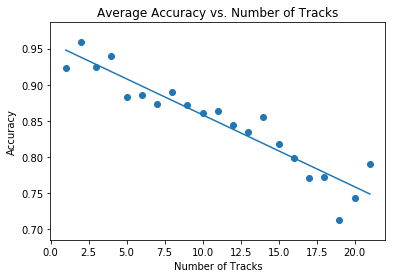

In [22]:
plt.scatter(track, accuracy)
plt.plot(np.unique(track), np.poly1d(np.polyfit(track, accuracy, 1))(np.unique(track)))
plt.title("Average Accuracy vs. Number of Tracks")
plt.xlabel("Number of Tracks")
plt.ylabel("Accuracy")
plt.show(fig)

In [ ]:
for i, cell in enumerate(acc):
    if cell < 0.3:
        print(cell)
        print(tracks[i])